In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from utils import setup_plotting_standards, basic_formatting
import seaborn as sns
import numpy as np
import statsmodels.api as sm

setup_plotting_standards()
COLOR = '#343434'

rename_dict = {"Democratic Republic of the Congo" : "DRC"}

# Figure 3: Dynamics of cross-border transmission
Here we attempt to quantify the magnitude and timing of cross-border transmissions between CholGEN Member States, as represented by Markov jumps from a discrete state phylogeographic reconstruction.

First, we load the Markov jumps from the discrete state analysis. This table is generated by running the `TreeMarkovJumpHistoryAnalyzer` on the posterior distribution of trees from the discrete-state reconstruction performed with BEAST. We alphabetize the start and end location because we're not interested in directionality.

In [4]:
def swap_locations( entry ):
    if entry['startLocation'] > entry['endLocation']:
        entry['startLocation'], entry['endLocation'] = entry['endLocation'], entry['startLocation']
    return entry

jumps = pd.read_csv( "../beast-analyses/2024-08-06_constant_relaxed_discrete.Location.csv" )
jumps["year"] = jumps["time"].round( 0 ).astype( int )
sorted_jumps = jumps.apply( swap_locations, axis=1 )
sorted_jumps.head()

,treeId,startLocation,endLocation,time,year
0,50000,Democratic Republic of the Congo,SetW,2016.862392,2017
1,50000,Cameroon,Nigeria,2020.093787,2020
2,50000,Cameroon,Nigeria,2019.257301,2019
3,50000,Cameroon,SetE,2000.969430,2001
4,50000,Cameroon,SetE,2008.940009,2009


We limit this analysis to locations pairs with a Markov jumps in at least 50% of the posterior.

In [5]:
totals = sorted_jumps.groupby( ['startLocation', "endLocation", "treeId"] )["time"].agg( "count" ).reset_index()
totals = totals.groupby( ["startLocation", "endLocation"] )["time"].describe( percentiles=[0.025, 0.5, 0.975] ).sort_values( "50%", ascending=False ).reset_index()

selected = totals.loc[(~totals["startLocation"].isin(["Other", "SetE", "SetW"]))&(~totals["endLocation"].isin(["Other", "SetE", "SetW"]))&(totals["count"]>(901*0.5))]
selected.head()

,startLocation,endLocation,count,mean,std,min,2.5%,50%,97.5%,max
0,Kenya,Tanzania,901.0,28.722531,3.103516,21.0,23.0,28.0,35.0,43.0
1,Cameroon,SetE,901.0,17.721421,1.954220,12.0,14.0,18.0,22.0,25.0
2,Democratic Republic of the Congo,Zambia,901.0,15.025527,1.520385,11.0,12.0,15.0,18.0,21.0
3,Nigeria,SetE,901.0,15.447281,1.900510,10.0,12.0,15.0,19.0,24.0
4,Malawi,South Africa,901.0,14.225305,1.619075,9.0,11.0,14.0,18.0,20.0


We calculate the median number of jumps observed between each location pair in the posterior, and structure these values as a matrix.

In [14]:
hm = jumps.pivot_table( index="treeId", columns=["startLocation", "endLocation"], values="time", aggfunc="count", fill_value=0, dropna=False )
hm = hm.describe( percentiles=[0.025, 0.5, 0.975])    
hm = hm.T.reset_index()
hm = hm.pivot( index="startLocation", columns="endLocation", values="50%" )

order = ["Ghana", "Nigeria", "Cameroon", "Democratic Republic of the Congo", "Kenya", "Uganda", "Tanzania", "Zambia","Malawi", "Mozambique", "South Africa"]
hm = hm.reindex( columns=order, index=order )
hm = hm.rename( columns=rename_dict, index=rename_dict )
hm = hm + hm.T

hm

endLocation,Ghana,Nigeria,Cameroon,DRC,Kenya,Uganda,Tanzania,Zambia,Malawi,Mozambique,South Africa
startLocation,,,,,,,,,,,
Ghana,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nigeria,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cameroon,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DRC,0.0,0.0,0.0,0.0,0.0,3.0,8.0,15.0,0.0,0.0,0.0
Kenya,0.0,0.0,0.0,0.0,0.0,3.0,29.0,3.0,0.0,0.0,0.0
Uganda,0.0,0.0,0.0,3.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0
Tanzania,0.0,0.0,0.0,8.0,29.0,5.0,0.0,2.0,0.0,0.0,0.0
Zambia,0.0,0.0,0.0,15.0,3.0,0.0,2.0,0.0,12.0,2.0,0.0
Malawi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,10.0,14.0


We mask the matrix so only the lower triangle can be seen (i.e. no redundant values).

In [21]:
mask = np.diag( np.ones( hm.shape[1] ) )
mask[np.triu_indices_from(hm.to_numpy())] = True
masked_data = np.ma.masked_array(hm.to_numpy(), mask )

We plot the median number of jumps between each location pair as a heatmap. This generates figure 3A.

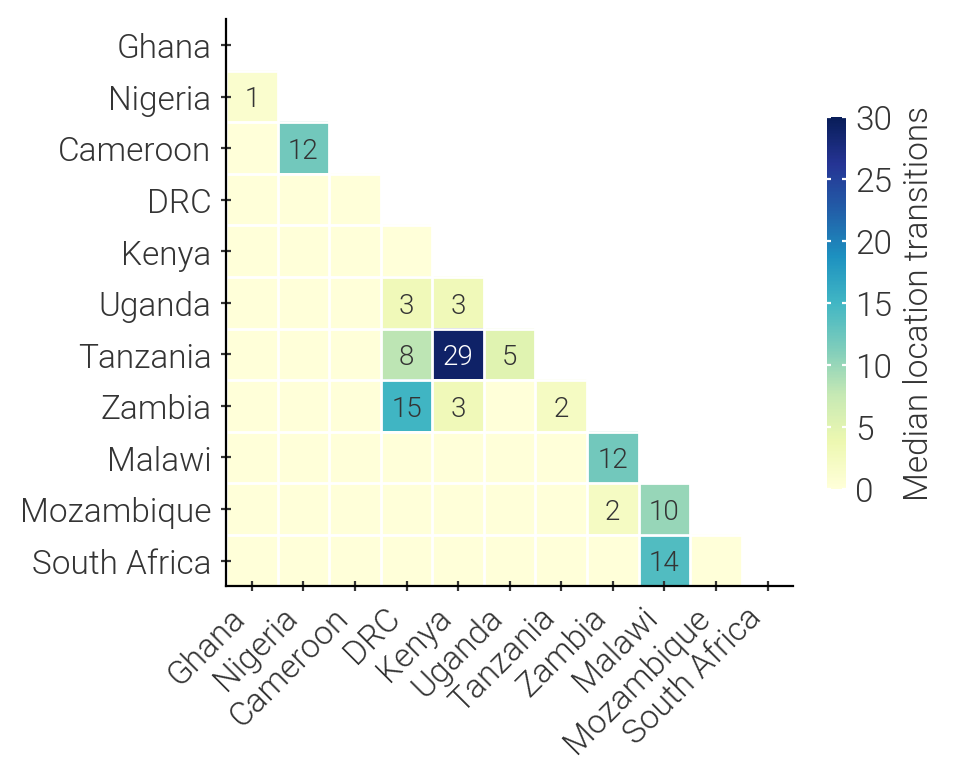

In [24]:
fig, ax = plt.subplots( figsize=(5,5) )

f1 = ax.imshow( masked_data, cmap="YlGnBu", vmin=0, vmax=30, interpolation="nearest" )

ax.set_xticks( range( hm.shape[0] ), minor=False )
ax.set_xticks( [i-0.5 for i in range( hm.shape[0] )], minor=True )
ax.set_xticklabels( hm.columns, ha="right" )
ax.tick_params( axis="x", which="major", rotation=45)

ax.set_yticks( range( hm.shape[1] ) )
ax.set_yticks( [i-0.5 for i in range( hm.shape[1] )], minor=True )
ax.set_yticklabels( hm.index )

cbar = plt.colorbar( f1, ax=ax, orientation="vertical", fraction=0.11, shrink=0.47, pad=0.05, ticks=[0,5,10,15,20,25,30] )
cbar.outline.set_visible( False )
cbar.set_label( "Median location transitions", fontsize=12 )
cbar.ax.tick_params( labelsize=12, size=1.5, left=True, right=True, color="w", direction="in" )
cbar.ax.minorticks_off()

basic_formatting( ax, xsize=12, ysize=12, ) #ylabel="From", xlabel="To")

for i in range( hm.shape[0] ):
    for j in range( hm.shape[1] ):
        if i < j:
            value = int( hm.iloc[j,i] )
            if value > 0:
                ax.text( i, j+0.05, value, ha="center", va="center", color=COLOR if value < 16 else "w", size=10 )

ax.grid( False, which="Both" )
ax.grid( which="minor", axis="both", color="w", linewidth=1)

ax.tick_params( axis="y", which="minor", left=False)
ax.tick_params( axis="x", which="minor", bottom=False )

plt.tight_layout()
plt.savefig( "plots/figure3-median-markov-jumps-heatmap.pdf")
plt.show()

To determine if Markov jumps are consistent or inconsistent over time, we calculate the number of Markov jumps occuring between each supported location pair per year.

In [7]:
yearly_jumps = sorted_jumps.pivot_table( index=["startLocation", "endLocation"], columns="year", values="time", aggfunc="count", fill_value=0 )
yearly_jumps = yearly_jumps.reset_index()

yjs = selected.merge( yearly_jumps, how="left", on=["startLocation", "endLocation"] )
yjs["path"] = yjs["startLocation"].replace( rename_dict ) + "-" + yjs["endLocation"].replace( rename_dict )
yjs = yjs.iloc[:,10:].set_index( "path" )
yjs = yjs.reindex( columns=range( int(yjs.columns.min()), int(yjs.columns.max()) ) )
yjs = yjs.fillna(0)

normed_yjs = yjs.div( yjs.sum(axis=1), axis=0 )

yjs.head()

year,startLocation,endLocation,1931,1932,1933,1939,1941,1942,1946,1951,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Cameroon,Democratic Republic of the Congo,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cameroon,Ghana,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cameroon,Malawi,0,0,0,0,0,0,0,0,...,7,0,1,0,0,0,0,0,0,0
3,Cameroon,Mozambique,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cameroon,Nigeria,0,0,0,0,0,0,0,0,...,24,909,705,3073,1787,128,73,839,30,4


Here we calculate the number of genomes that are available for each supported location pair per year.

In [11]:
md = list()
for file in ["supplemental_data1.csv", "supplemental_data2.csv"]:
    df = pd.read_csv( "../data/" + file, usecols=["taxa", "country", "collection_year"] )
    md.append( df )
    
md = pd.concat( md )

seq_counts = md.pivot_table( index="country", columns="collection_year", values="taxa", aggfunc="count", fill_value=0 )

plot_df = list()
for _, row in selected.iterrows():
    pair_counts = seq_counts.loc[[row["startLocation"],row["endLocation"]]].sum()  # as opposed to min()
    pair_counts.name = row["startLocation"].replace( "Democratic Republic of the Congo", "DRC" ) + "-" + row["endLocation"].replace( "Democratic Republic of the Congo", "DRC" )
    plot_df.append( pair_counts )
   
plot_df = pd.concat( plot_df, axis=1 ).T
plot_df = plot_df.reindex( columns=range( int(plot_df.columns.min()), int(plot_df.columns.max()) ) )
plot_df = plot_df.fillna( 0 )
plot_df.head()

collection_year,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Kenya-Tanzania,0,0.0,0.0,0.0,0,0,0,0,0,0,...,0,43,15,40,18,3,0,0,0,0
DRC-Zambia,0,0.0,0.0,0.0,0,0,0,0,0,0,...,22,33,30,3,0,0,0,30,77,158
Malawi-South Africa,0,0.0,0.0,0.0,0,0,0,0,0,0,...,0,4,6,2,10,0,0,0,58,171
Cameroon-Nigeria,0,0.0,0.0,0.0,0,0,0,0,0,0,...,2,0,0,0,54,32,1,21,31,30
Malawi-Zambia,0,0.0,0.0,0.0,0,0,0,0,0,0,...,0,4,14,3,8,0,0,0,58,138


Here we plot the temporal distribution of Markov jumps and genomic surveillance using a heatmap. This generates figure 3B.

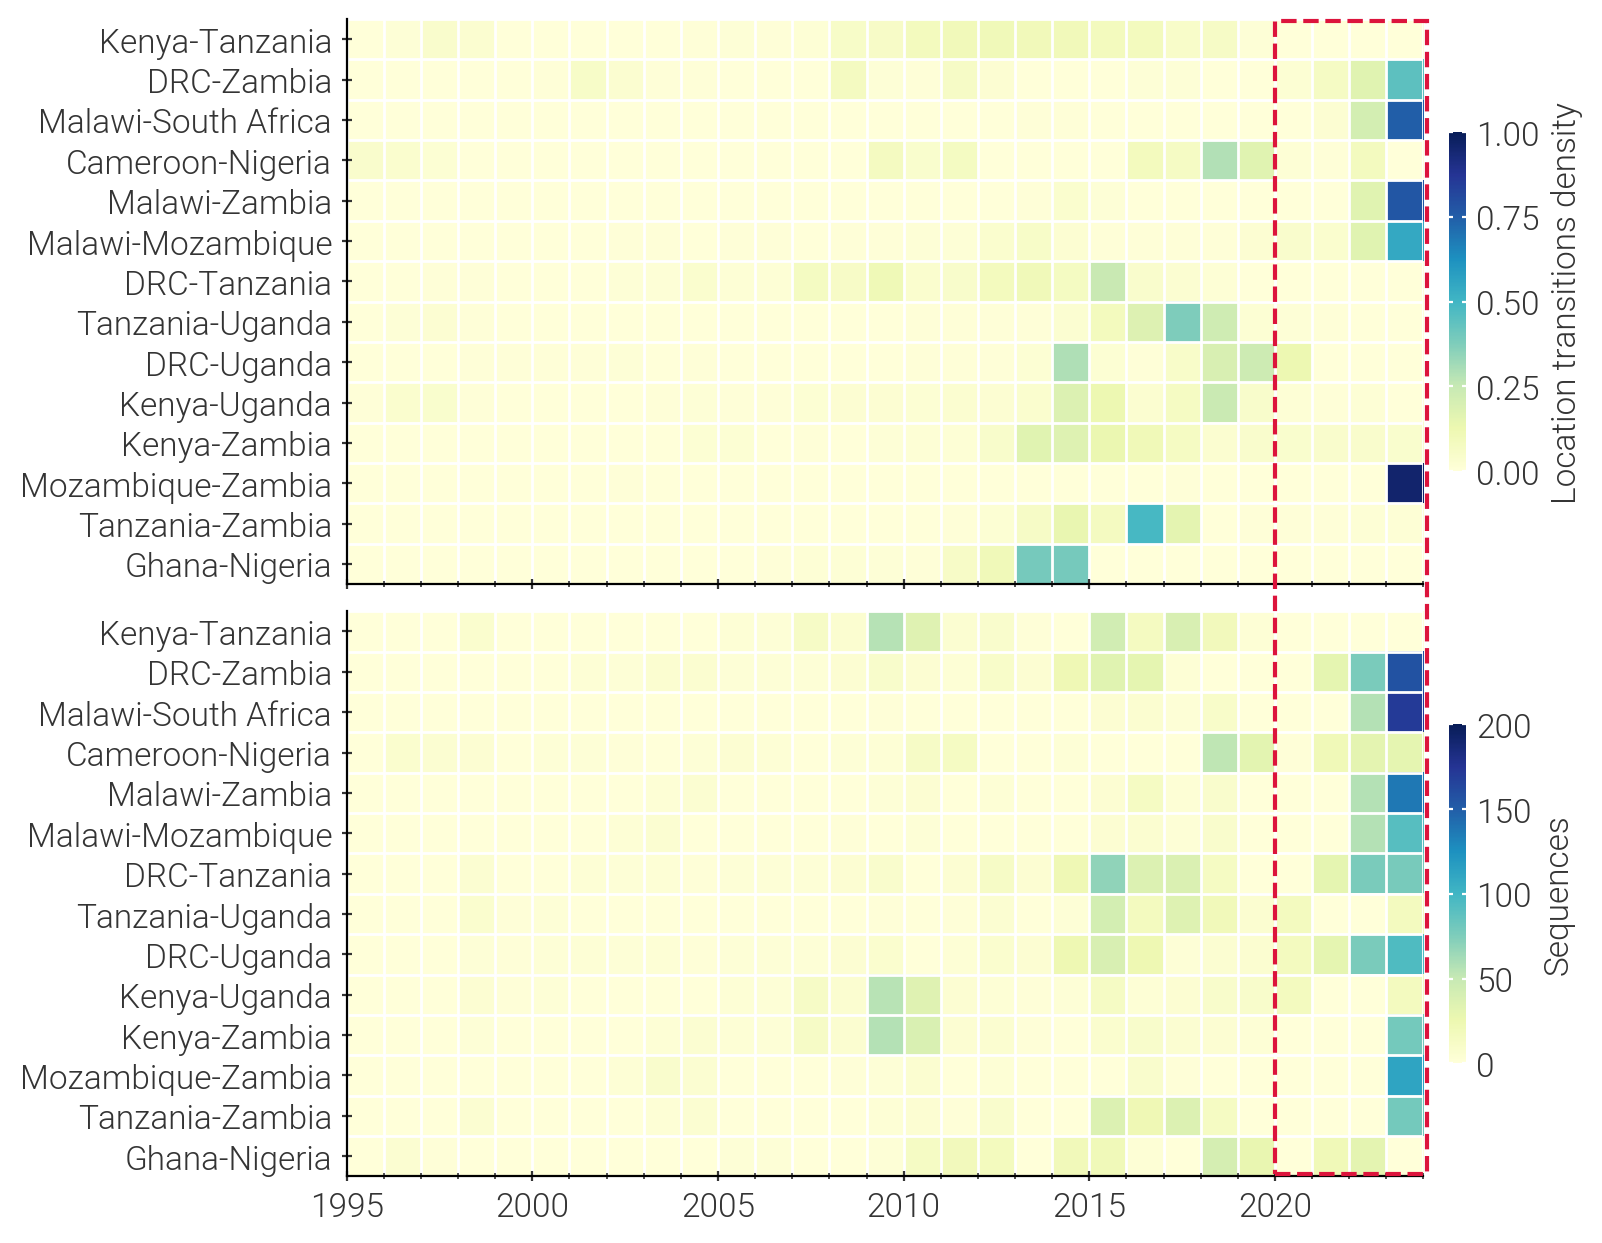

In [16]:
fig, ax = plt.subplots( figsize=(8.6,6.5), nrows=2 )
f1 = ax[0].imshow( normed_yjs, aspect="auto", cmap="YlGnBu", interpolation="nearest", vmin=0, vmax=1, extent=( min( yjs.columns ), min( yjs.columns ) + yjs.shape[1], yjs.shape[0]-0.5, -0.49 ) )

ax[0].set_yticks( range( yjs.shape[0] ) )
ax[0].set_yticks( [i - 0.5 for i in range( yjs.shape[0] )], minor=True )
ax[0].set_yticklabels( yjs.index )

ax[0].set_xticks( range( 1970, 2030, 5 ), minor=False )
ax[0].set_xticks( range( 1970, 2030 ), minor=True )

basic_formatting( ax[0], xlims=(1995,2024), xsize=12, ysize=12)

ax[0].grid( False, which="Both" )
ax[0].grid( which="minor", axis="y", color="w")
ax[0].grid( which="both", axis="x", color="w", linewidth=1)

cbar = plt.colorbar( f1, ax=ax[0], orientation="vertical", shrink=0.6, pad=0.02, ticks=[0,0.25,0.5,0.75,1] )
cbar.outline.set_visible( False )
cbar.set_label( "Location transitions density", fontsize=12 )
cbar.ax.tick_params( labelsize=12, size=1.5, left=True, right=True, color="w", direction="in" )
cbar.ax.minorticks_off()

ax[0].tick_params( axis="y", which="minor", left=False)
ax[0].label_outer()
ax[0].set_xticklabels([])

# Bottom
f1 = ax[1].imshow( plot_df, cmap="YlGnBu", aspect="auto", interpolation="nearest", vmin=0, vmax=200, extent=( min( plot_df.columns ), min( plot_df.columns ) + plot_df.shape[1], plot_df.shape[0]-0.5, -0.49 ) )

ax[1].set_yticks( range( plot_df.shape[0] ) )
ax[1].set_yticks( [i - 0.5 for i in range( plot_df.shape[0] )], minor=True )
ax[1].set_yticklabels( plot_df.index )

ax[1].set_xticks( range( 1970, 2030, 5 ), minor=False )
ax[1].set_xticks( range( 1970, 2030 ), minor=True )

basic_formatting( ax[1], xlims=(1995,2024), xsize=12, ysize=12)

ax[1].grid( False, which="Both" )
ax[1].grid( which="minor", axis="y", color="w")
ax[1].grid( which="both", axis="x", color="w", linewidth=1)

cbar = plt.colorbar( f1, ax=ax[1], orientation="vertical", shrink=0.6, pad=0.02, ticks=[0,50,100,150,200] )
cbar.outline.set_visible( False )
cbar.set_label( "Sequences", fontsize=12 )
cbar.ax.tick_params( labelsize=12, size=1.5, left=True, right=True, color="w", direction="in" )
cbar.ax.minorticks_off()

ax[1].tick_params( axis="y", which="minor", left=False)

plt.tight_layout(h_pad=0.5)
rect = plt.Rectangle((2020,0.005), width=4.1, height=1.84+fig.subplotpars.wspace,
                     transform=ax[1].get_xaxis_transform(), clip_on=False,
                     edgecolor="crimson", facecolor="none", linewidth=1.5, linestyle="dashed", zorder=100)
ax[1].add_patch(rect)

plt.savefig( "plots/figure3-markov-jumps-sequences-supported-over-time.pdf" )
plt.show()

To quantify the relationship between Markov jumps and genomic surveillance, we merge the two dataframes so its more ammenable to fitting a linear regression.

In [12]:
yjs_long = yjs.reset_index().melt( id_vars="path", var_name="year", value_name="jumps" )
seqs_long = plot_df.reset_index().melt( id_vars="index", var_name="year", value_name="sequences" )
seqs_long = seqs_long.rename( columns={"index": "path"})
seqs_long["year"] = seqs_long["year"]

seqs_jumps = yjs_long.merge( seqs_long, on=["path", "year"], how="outer" )
seqs_jumps["jumps"] = seqs_jumps["jumps"].fillna(0)
seqs_jumps["sequences"] = seqs_jumps["sequences"].fillna( 0 )
seqs_jumps


,path,year,jumps,sequences
0,Cameroon-Nigeria,1931,0.0,0.0
1,Cameroon-Nigeria,1932,0.0,0.0
2,Cameroon-Nigeria,1933,0.0,0.0
3,Cameroon-Nigeria,1934,0.0,0.0
4,Cameroon-Nigeria,1935,0.0,0.0
...,...,...,...,...
1297,Tanzania-Zambia,2019,13.0,0.0
1298,Tanzania-Zambia,2020,13.0,0.0
1299,Tanzania-Zambia,2021,15.0,0.0
1300,Tanzania-Zambia,2022,30.0,0.0


We plot the number of markov jumps observed vs. the number of genomes collected for each location pair and year, and calculate the correlation between the two using linear regression. This generates figure 3C.

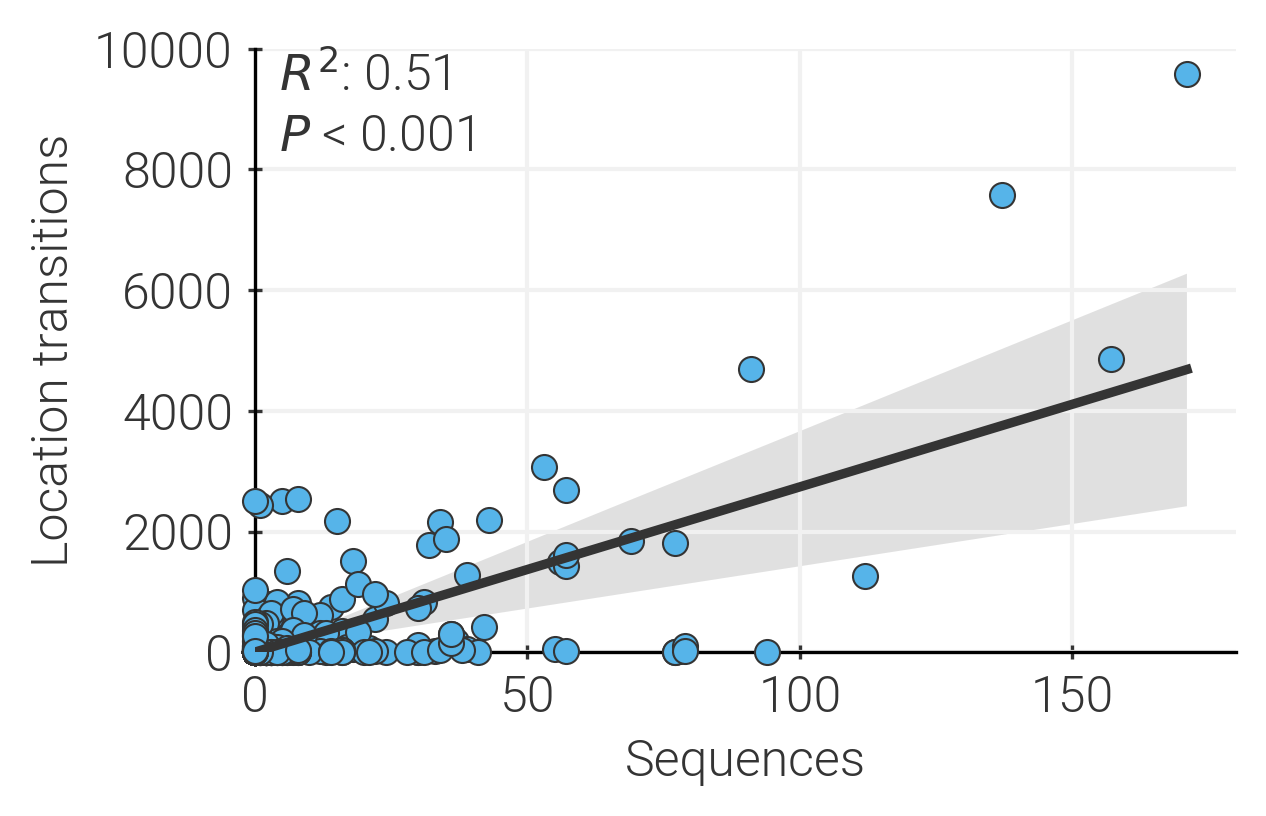

In [13]:
fig, ax = plt.subplots( dpi=300, figsize=(4.5,3) )
pts = ax.scatter( "sequences", "jumps", data=seqs_jumps, color="#56B4E9", edgecolor=COLOR, linewidth=0.5, zorder=10 )
pts.set_clip_on( False )
sns.regplot( x="sequences", y="jumps", data=seqs_jumps, scatter=False, color=COLOR, line_kws={"zorder" : 20} )

X = seqs_jumps["sequences"]
y = seqs_jumps["jumps"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

r2_score = est2.rsquared
r2_score_str = f"$R^2$: {r2_score:.2f}"
p_value = est2.pvalues["sequences"]
p_value_str = f"$P$: {p_value:.3f}" if p_value > 0.001 else "$P$ < 0.001"

ax.annotate( r2_score_str, xy=(0.025, 0.93), xycoords="axes fraction", fontsize=12)
ax.annotate( p_value_str , xy=(0.025, 0.83), xycoords="axes fraction", fontsize=12)

basic_formatting( ax, which="both", xlims=(0,180), ylims=(0,10000), xlabel="Sequences", ylabel="Location transitions", xsize=12, ysize=12 )

plt.tight_layout()
plt.savefig( "plots/figure3-sequences-vs-jumps.pdf", transparent=True )
plt.show()